In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import math

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [21]:
tqdm.pandas()

In [22]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [23]:
plt.rcParams.update({'font.size': 15})

In [24]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [25]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")
billboard_hot_100["last_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("max")
billboard_hot_100["start_end_week_diff"] = (billboard_hot_100["last_week"] - billboard_hot_100["first_week"]).dt.days / 7

In [26]:
min_first_week = billboard_hot_100["first_day_of_the_week"].min().to_pydatetime()
billboard_hot_100["first_day_of_the_week_copy"] = billboard_hot_100["first_day_of_the_week"]
billboard_hot_100["first_day_of_the_week"] = billboard_hot_100.progress_apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

100%|██████████| 336087/336087 [00:07<00:00, 42573.32it/s]


In [27]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["start_end_week_diff"] <= 50) & (billboard_hot_100["top_position"] <= 10)]

pv_table = billboard_hot_100.pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [28]:
pv_table

artist_song,"""Weird Al"" Yankovic - White & Nerdy",'N Sync & Gloria Estefan - Music Of My Heart,'N Sync - (God Must Have Spent) A Little More Time On You,'N Sync - Bye Bye Bye,'N Sync - It's Gonna Be Me,'N Sync - This I Promise You,'N Sync Featuring Nelly - Girlfriend,'Til Tuesday - Voices Carry,100 Proof Aged in Soul - Somebody's Been Sleeping,10cc - I'm Not In Love,...,Zhane - Hey Mr. D.J.,a-ha - Take On Me,"benny blanco, BTS & Snoop Dogg - Bad Decisions",fun. Featuring Janelle Monae - We Are Young,gnash Featuring Olivia O'Brien - I Hate U I Love U,matchbox twenty - Bent,matchbox twenty - If You're Gone,twenty one pilots - Heathens,twenty one pilots - Ride,will.i.am & Britney Spears - Scream & Shout
first_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,28,66,60,42,82,68,70,81,81,84,...,79,91,10,53,93,60,52,14,96,12
1,9,56,57,20,70,31,55,71,75,74,...,66,86,57,78,96,37,43,18,96,13
2,11,52,44,19,51,19,30,61,52,64,...,51,79,60,101,99,29,38,26,88,15
3,15,52,34,14,39,15,22,55,43,49,...,38,67,89,101,78,24,30,23,87,12
4,17,41,35,13,26,11,18,45,37,38,...,28,57,90,88,76,22,29,22,78,12
5,23,41,36,7,19,6,16,39,31,22,...,18,48,101,86,59,21,21,15,74,8
6,26,2,30,6,15,7,14,34,28,17,...,14,38,101,89,59,18,20,11,66,6
7,36,3,23,5,9,7,6,28,14,11,...,10,28,101,63,61,16,15,4,58,6
8,42,6,26,5,7,6,5,25,13,10,...,8,21,101,41,55,13,13,4,45,5


In [29]:
nmf = NMF(n_components=3, init='random', random_state=0)
nmf.fit(pv_table)

c:\Users\cutie\source\repos\mgr\env\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='random', n_components=3, random_state=0)

In [30]:
nmf_features = nmf.transform(pv_table)

In [31]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [32]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
Pips - Every Beat Of My Heart, Floyd Cramer - San Antonio Rose, Little Caesar and The Romans - Those Oldies But Goodies (Remind Me Of You), Billy Grammer - Gotta Travel On, The Fendermen - Mule Skinner Blues

Archetype  1
The Elegants - Little Star, Elvis Presley With The Jordanaires - Are You Lonesome To-night?, Billy Grammer - Gotta Travel On, Jimmy Jones - Handy Man, Della Reese - Don't You Know

Archetype  2
Fats Domino - Be My Guest, Johnny Preston - Running Bear, Jimmy Clanton And His Rockets - Just A Dream, The Jive Five With Joe Rene And Orchestra - My True Story, Elvis Presley With The Jordanaires - Stuck On You


In [33]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,Domenico Modugno - Nel Blu Dipinto Di Blu (Volare),The Elegants - Little Star,The Everly Brothers - Bird Dog,Jimmy Clanton And His Rockets - Just A Dream,Perez Prado And His Orchestra - Patricia,Ricky Nelson - Poor Little Fool,Jack Scott - My True Love,Bobby Day - Rock-in Robin,Frankie Avalon - Ginger Bread,The Olympics - Western Movies,...,Taylor Swift - Bejeweled,Taylor Swift - Question...?,"Taylor Swift - You're On Your Own, Kid",Taylor Swift - Karma,Taylor Swift - Vigilante Shit,Rihanna - Lift Me Up,"Metro Boomin, The Weeknd & 21 Savage - Creepin'","Metro Boomin, Future & Chris Brown - Superhero (Heroes & Villains)",SZA - Kill Bill,SZA - Nobody Gets Me
0,6.996215,7.542959,4.465081,4.094519,2.397056,2.841997,6.346891,5.545620,7.905138,7.465859,...,3.676388,2.951407,6.040987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.914191
1,2.914309,4.535785,0.070275,0.000000,0.000000,0.000000,0.000000,0.103011,3.452354,0.646925,...,0.000000,0.000000,9.629270,1.792689,5.013628,0.591225,1.008934,0.494974,2.661157,0.000000
2,2.759686,1.859165,8.412523,8.297512,11.592867,10.177472,5.026886,6.944419,1.717931,3.375172,...,9.576685,11.447764,3.583247,8.297344,9.707486,10.329494,9.441665,9.837106,10.536766,8.308709


In [34]:
# get all artist-songs for archetypes
archetypes = {i: [] for i in range(len(components_df.index))}
for artist_song in components_df.columns:
    archetype = components_df[artist_song].argmax()
    archetypes[archetype].append(artist_song)

In [35]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2
0,7.318887,0.000000,5.079046
1,4.829390,0.750464,4.618825
2,2.835624,1.883570,4.193144
3,1.456511,2.769399,3.720504
4,0.493328,3.567487,3.236232
5,0.000000,3.965114,2.784481
6,0.000000,3.944427,2.281676
7,0.000000,4.155092,1.847704
8,0.000000,4.750208,1.454424
9,0.000000,5.903440,1.097937


In [36]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + 1

            while week <= 101:
                rows_to_add.append({
                    "artist_song": row["artist_song"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_week": row["first_week"]
                })
                week += 1

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist_song",
    "weeks_on_chart", "position", "first_day_of_the_week", "first_week", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 4909/4909 [00:11<00:00, 409.49it/s]


3it [00:01,  2.03it/s]


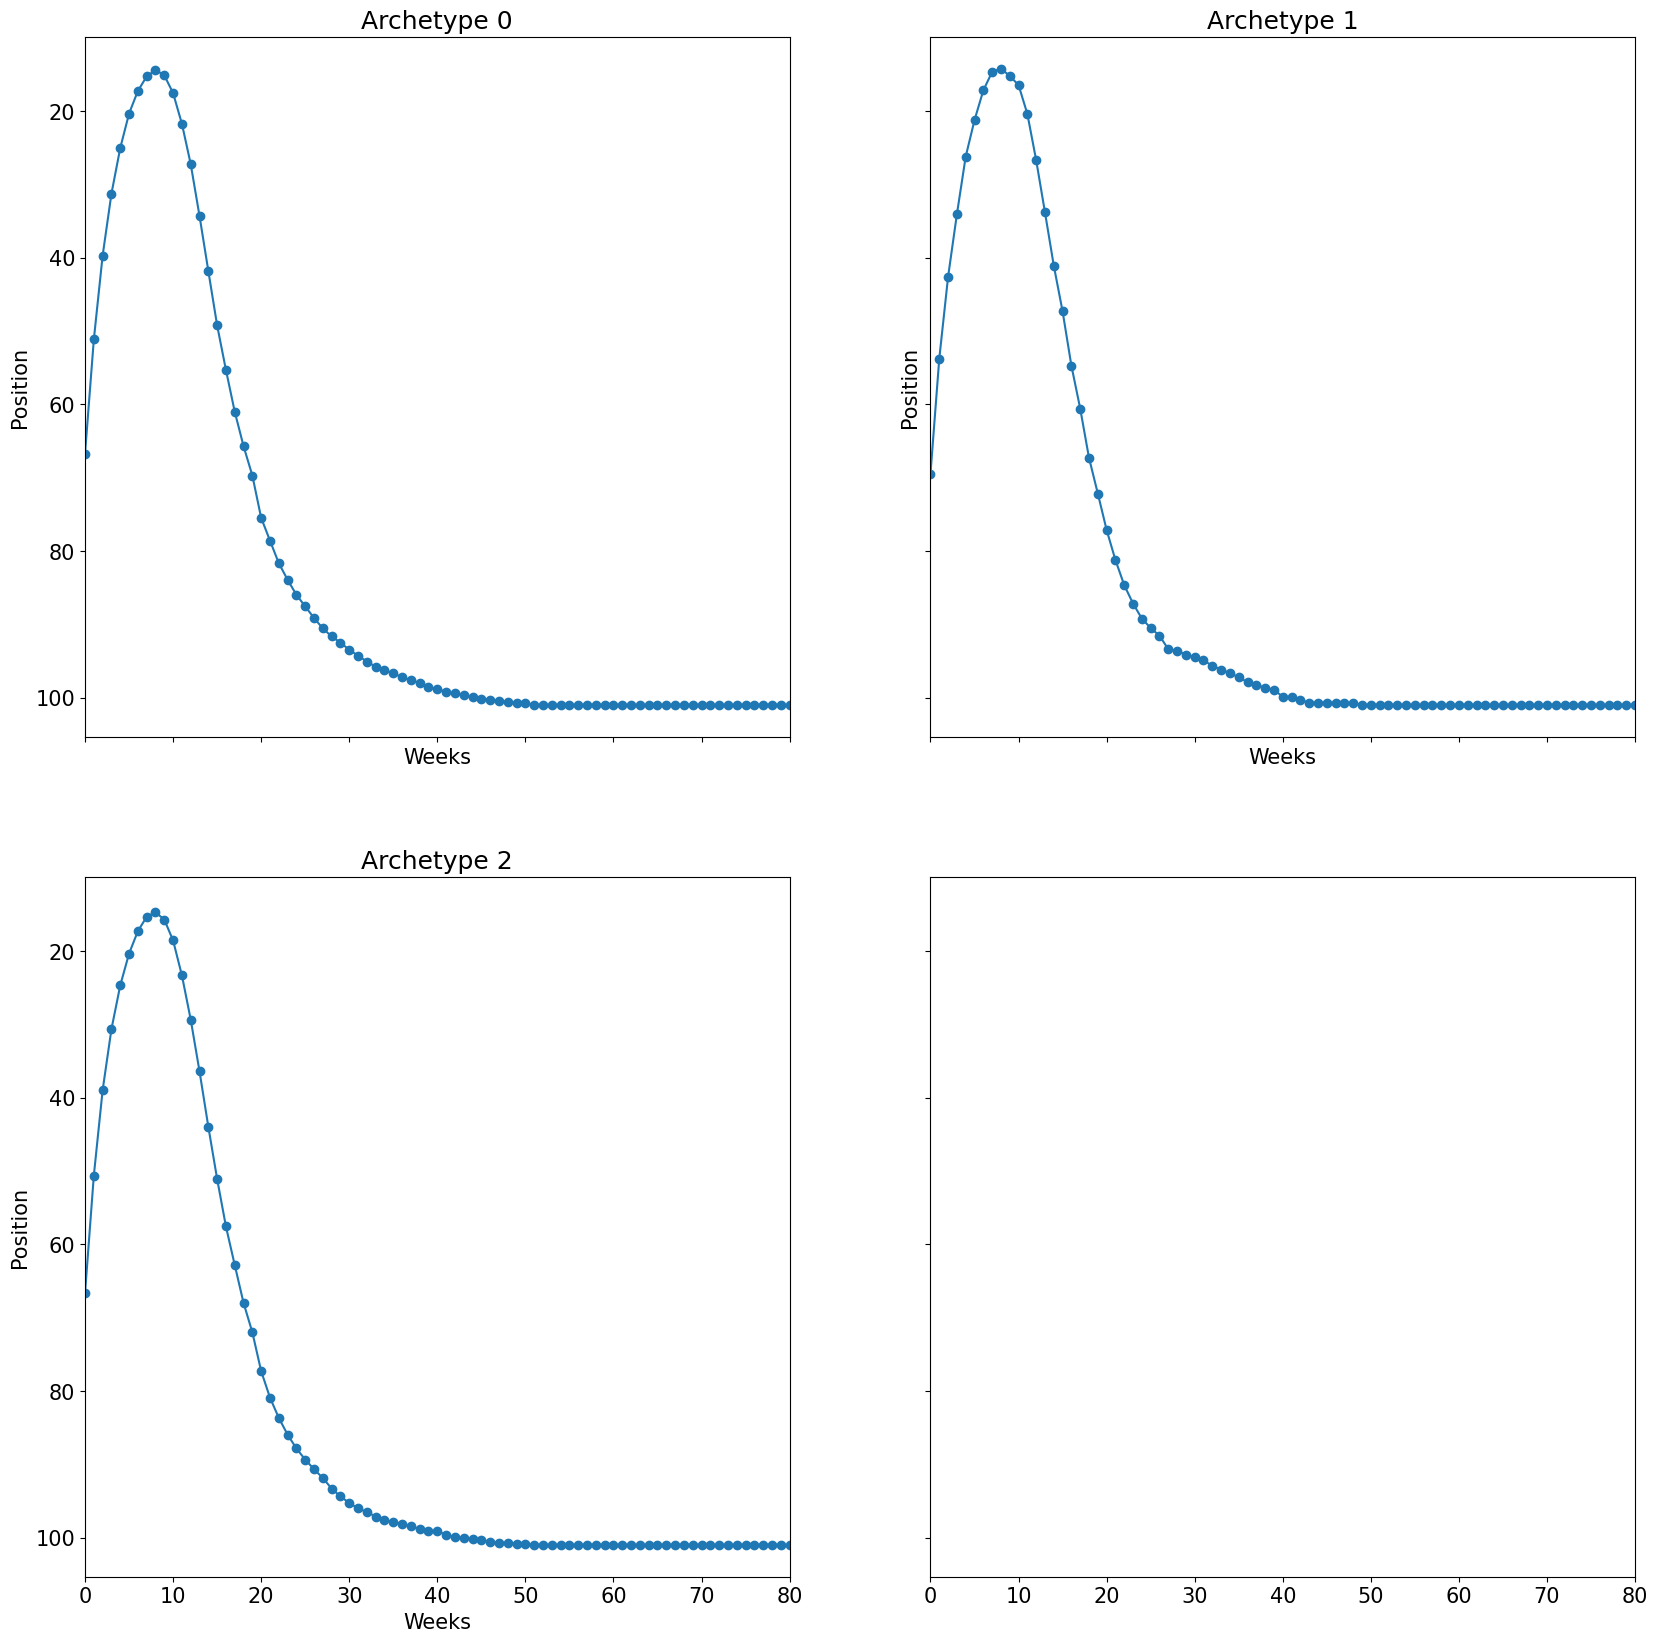

In [37]:
# plot all trajectories of archetypes
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(10, 110, 10):
        songs_ids_from_archetype = archetypes[ix]
        songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] <= top_position) &\
            (songs_from_archetype["top_position"] > top_position - 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1703.74it/s]
3it [00:03,  1.29s/it]


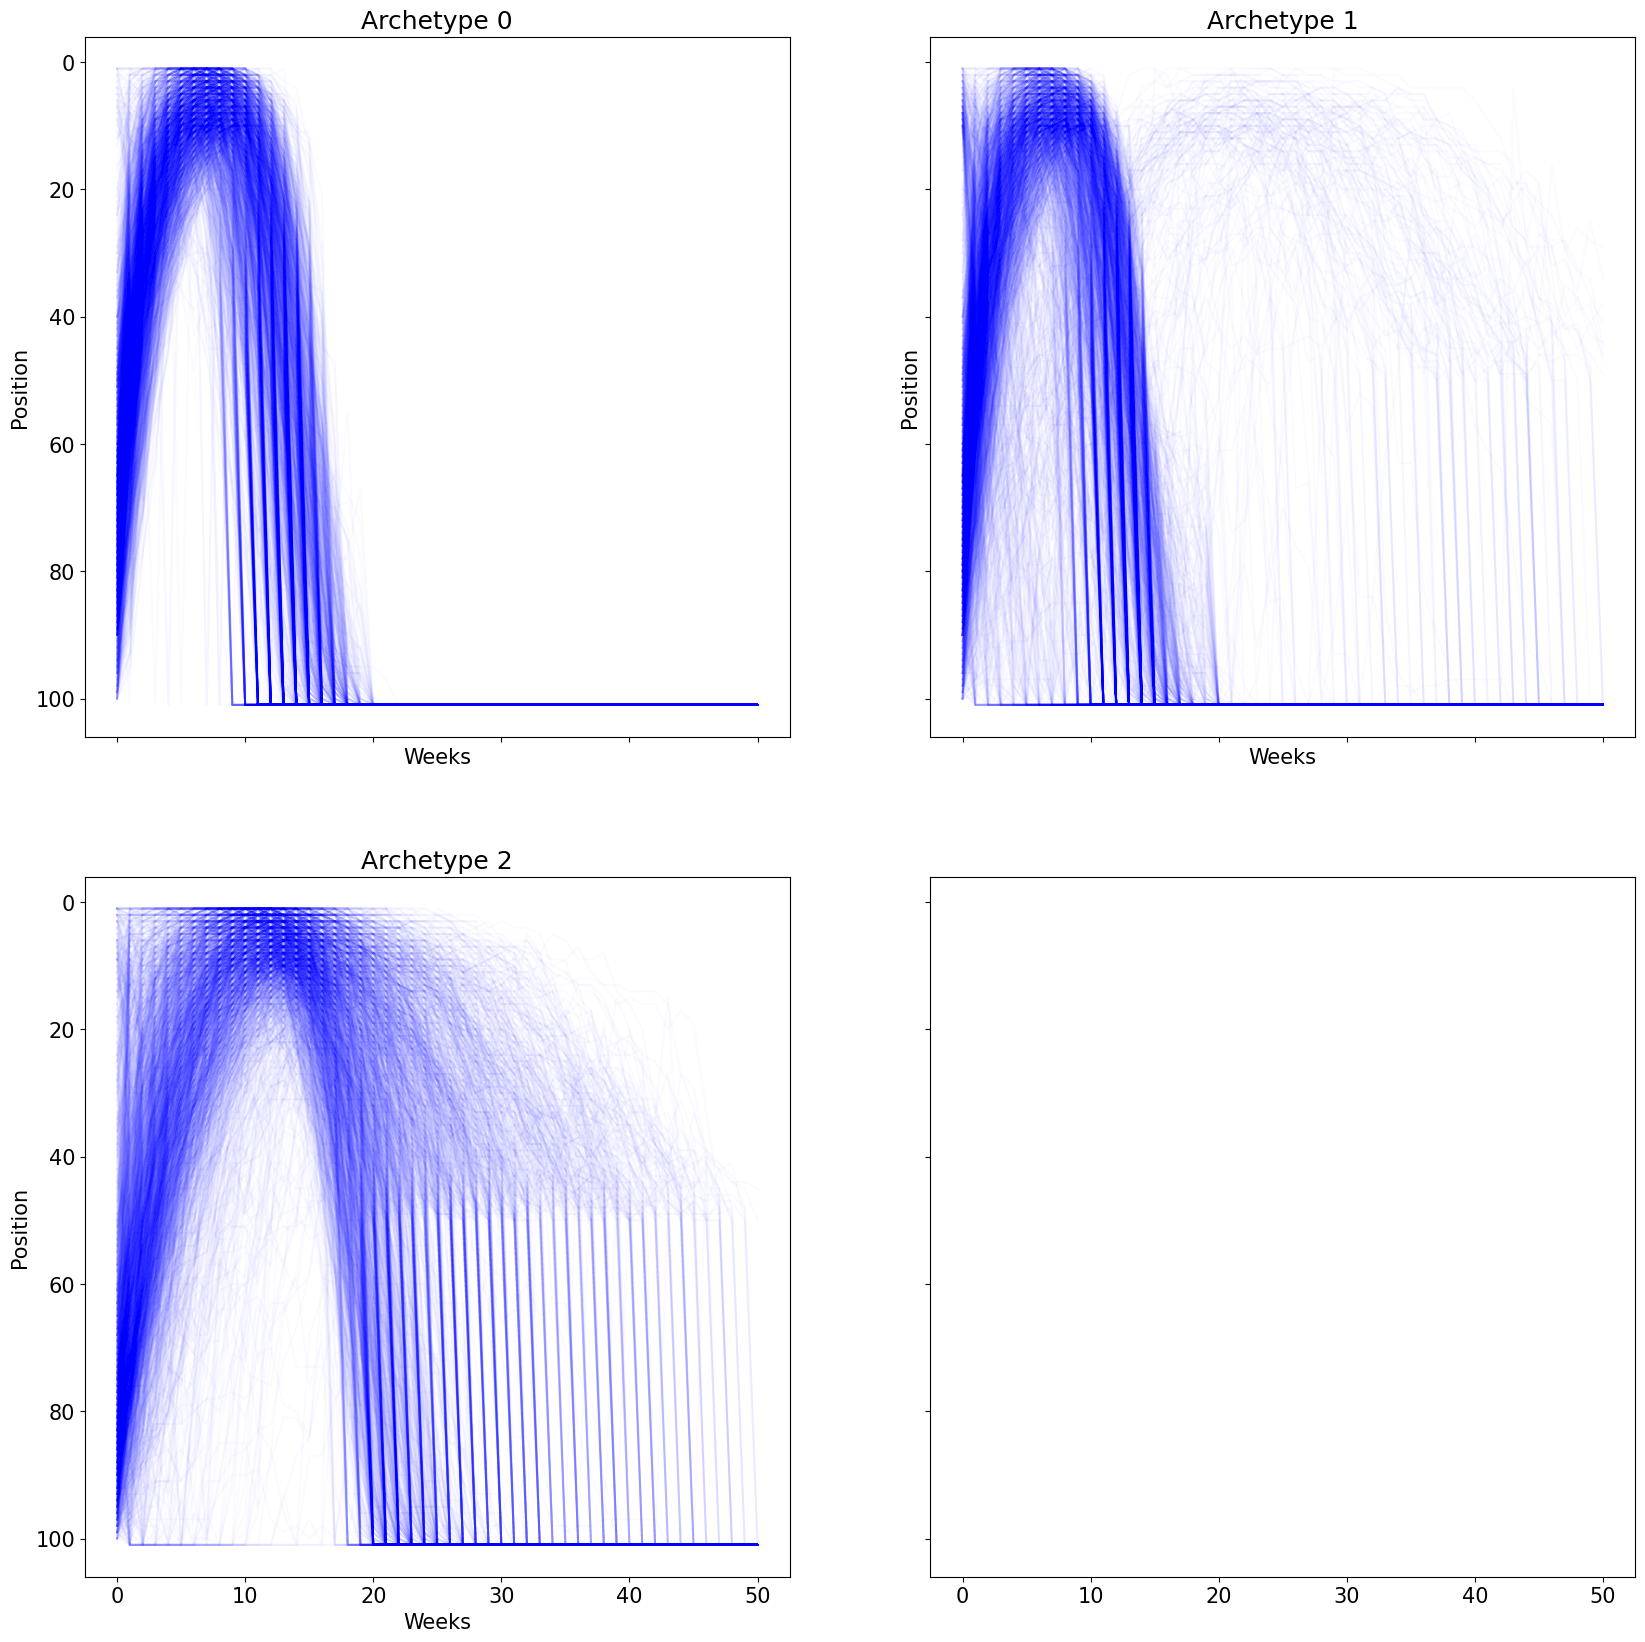

In [38]:
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = pv_table.iloc[:, i].values
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1190.98it/s]
3it [00:04,  1.43s/it]


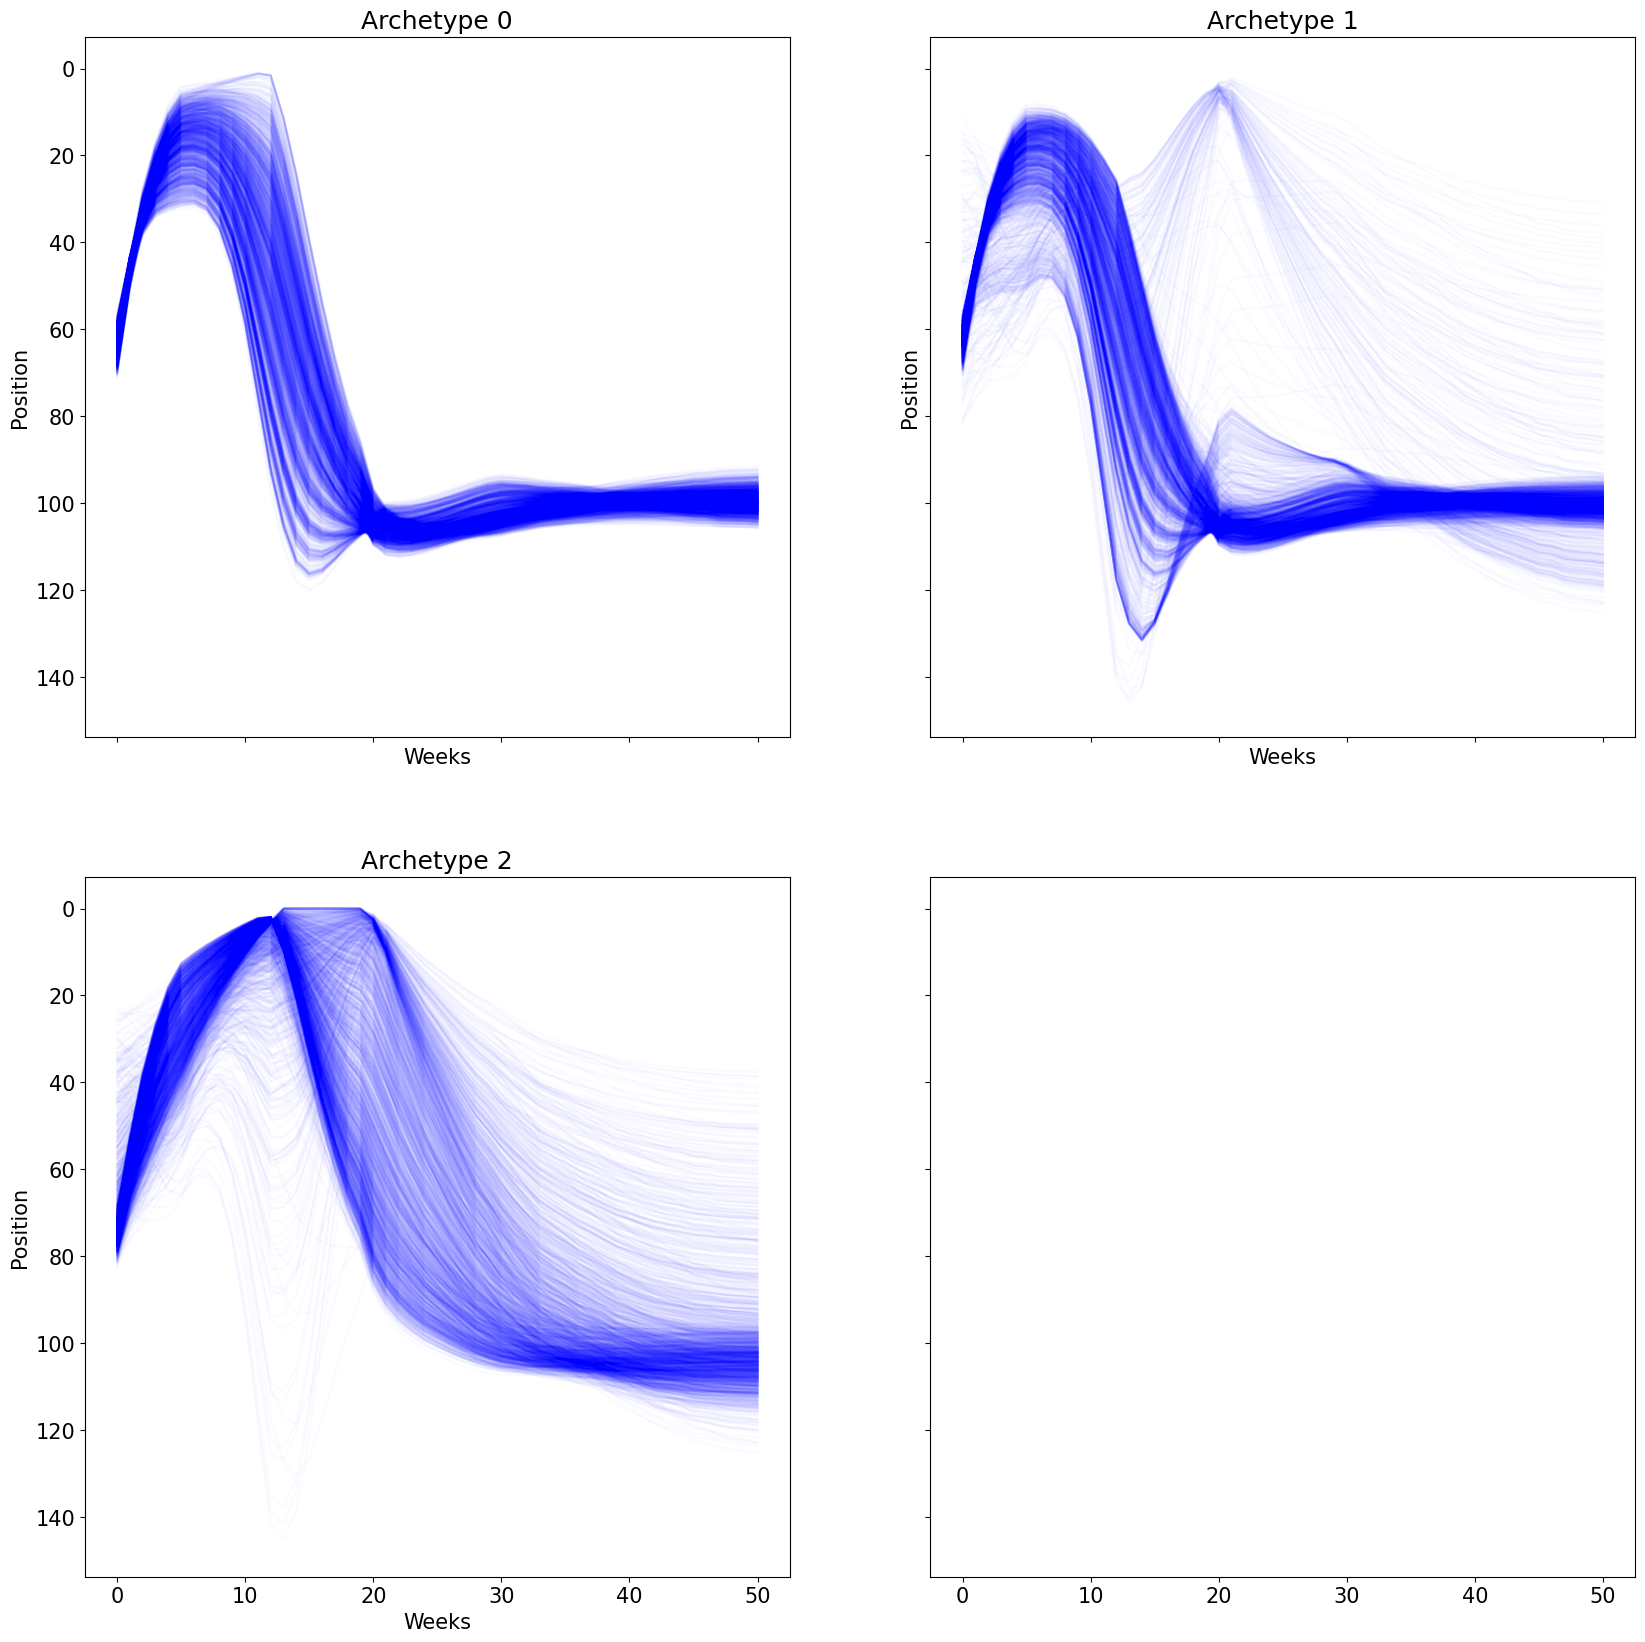

In [39]:
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = np.matmul(nmf_features_pd, components_df.values[:, i])
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1683.27it/s]
3it [00:04,  1.50s/it]


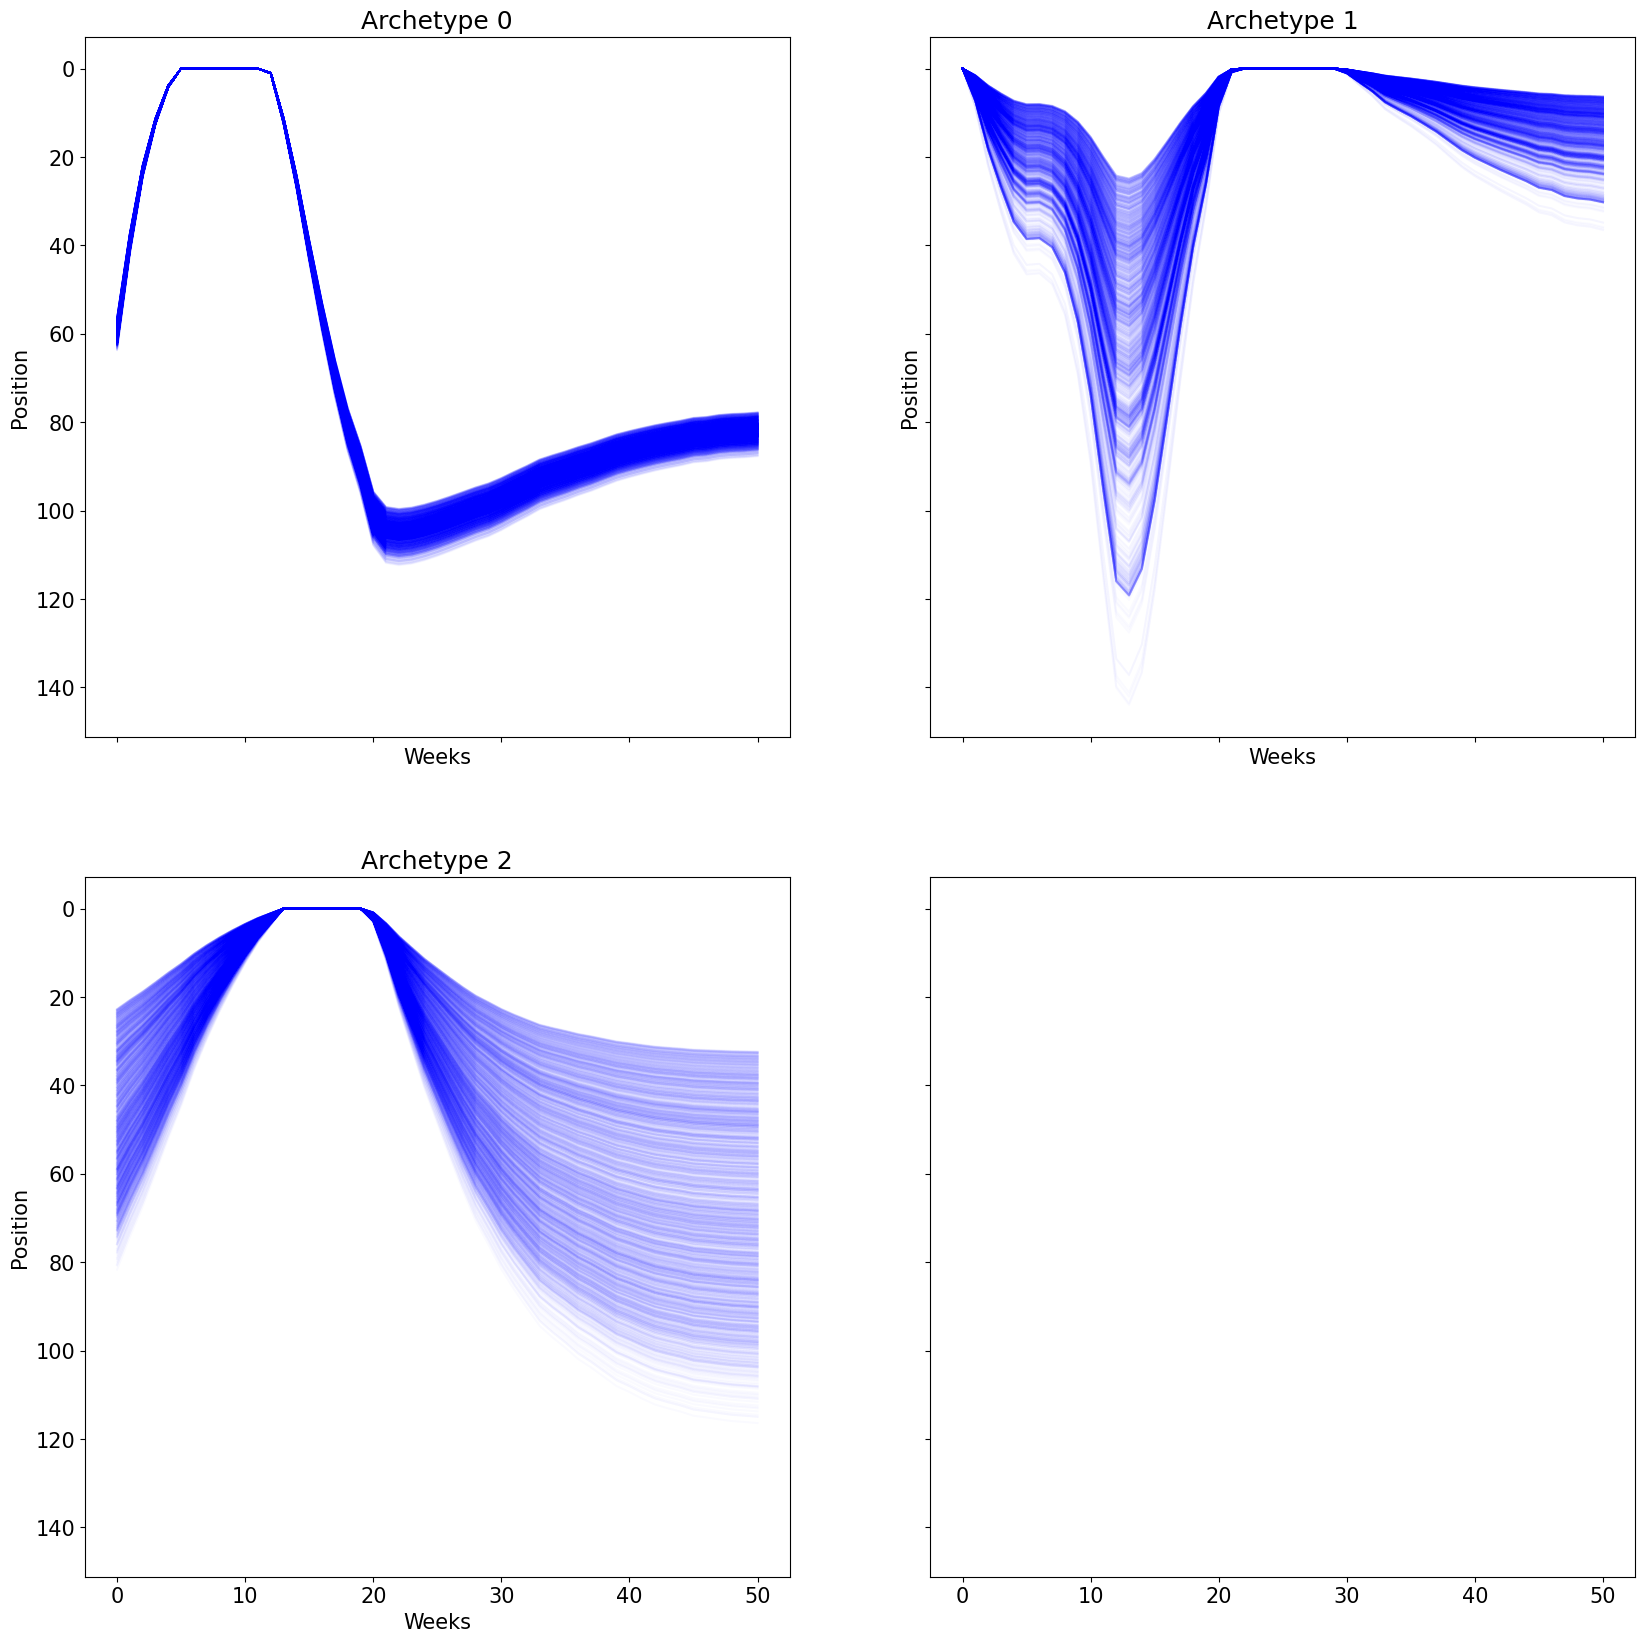

In [40]:
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = nmf_features_pd.values[:, ix] * components_df.values[ix, i]
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

In [41]:
billboard_hot_100["archetype"] = billboard_hot_100["artist_song"].progress_apply(lambda x: components_df[x].argmax())

100%|██████████| 98068/98068 [00:05<00:00, 19320.16it/s]


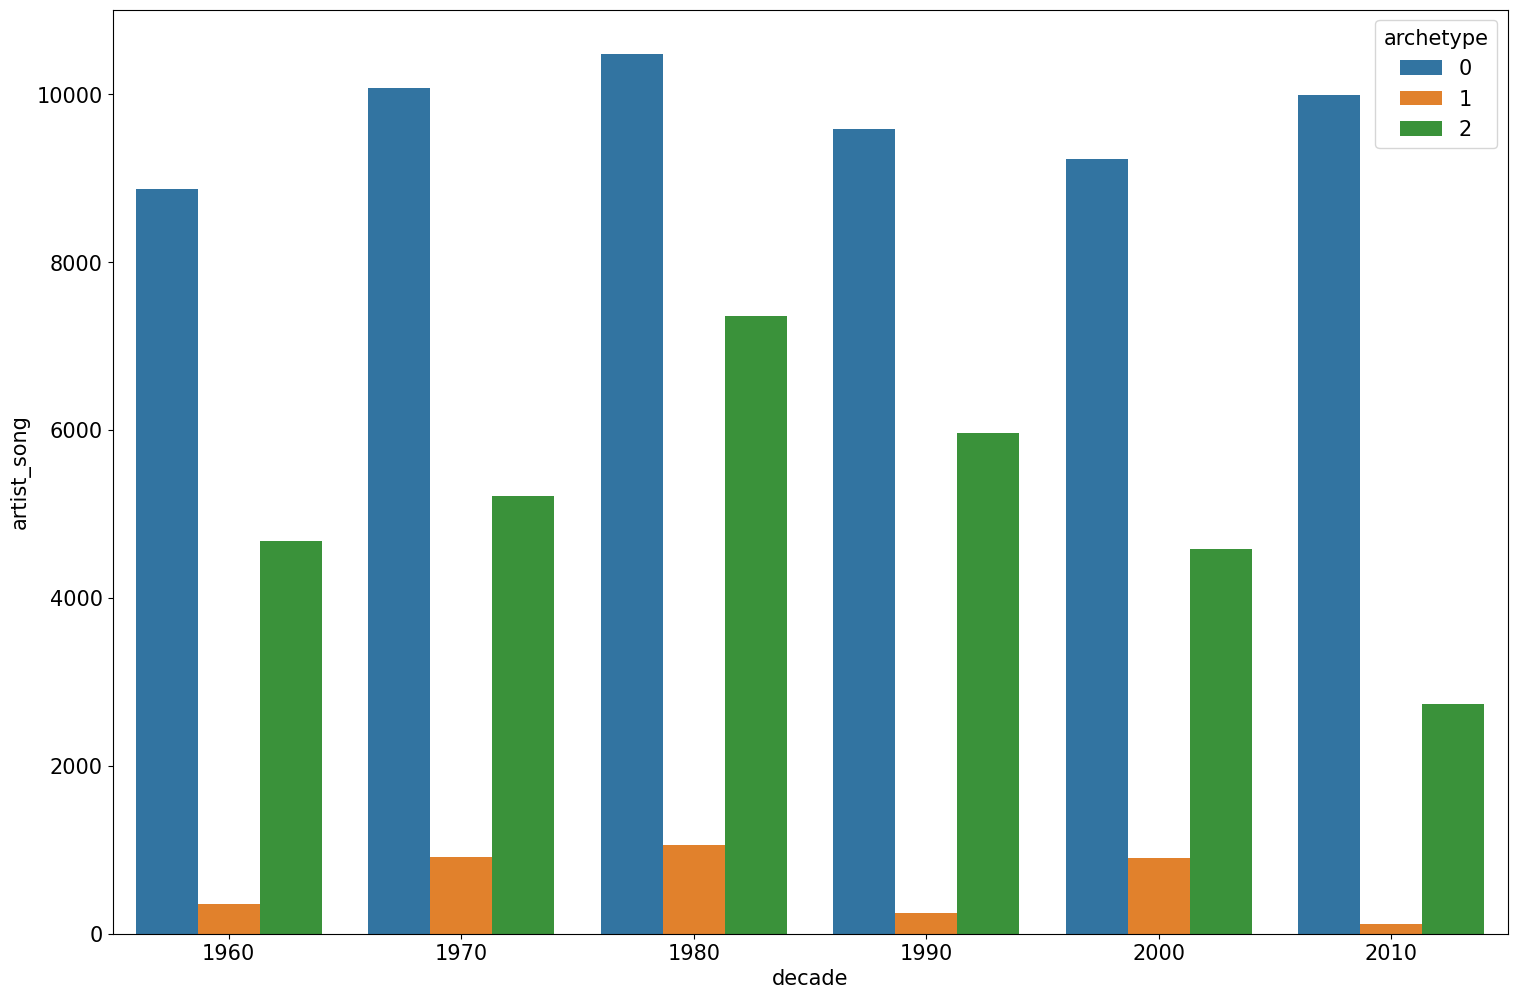

In [42]:
import seaborn as sns

plt.figure(figsize=(18, 12))

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week_copy"].dt.year
billboard_hot_100["decade"] = billboard_hot_100["year"].apply(lambda x: x - x % 10)
counts = billboard_hot_100[["archetype", "decade", "artist_song"]].groupby(["archetype", "decade"]).count().reset_index()
counts = counts[(counts["decade"] != 2020) & (counts["decade"] != 1950)]
sns.barplot(counts, x="decade", y="artist_song", hue="archetype")

plt.show()